In [74]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
import category_encoders as ce
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

In [2]:
df = pd.read_csv('transformed_df.csv')
df

,employer,employer_rating,sector,industry,employer_founded,employer_revenue,job_title,location,min_salary,max_salary,average_base_salary,estimator
0,Parsons,4.0,Information Technology,Information Technology Support Services,1944.0,$1 to $5 billion (USD),Data Scientist,Remote,100000.0,176000.0,138050.0,Employer
1,TriNet,3.7,Management & Consulting,Business Consulting,1988.0,$1 to $5 billion (USD),Data Scientist,Remote,76000.0,182000.0,129200.0,Employer
2,Cotiviti,3.7,Information Technology,Information Technology Support Services,1979.0,$500 million to $1 billion (USD),Data Scientist I,Remote,93000.0,109000.0,101000.0,Employer
3,Alliant Credit Union,3.3,Financial Services,Banking & Lending,1935.0,$5 to $25 million (USD),Data Scientist - Hybrid,"Chicago, IL",115000.0,142000.0,127549.0,Glassdoor
4,"NextDeavor, Inc.",4.5,NaN,NaN,NaN,Unknown / Non-Applicable,"Data Scientist, Product Insights","San Francisco, CA",172800.0,202809.6,187795.2,Employer
...,...,...,...,...,...,...,...,...,...,...,...,...
1866,Plaid,4.1,Information Technology,Enterprise Software & Network Solutions,2012.0,Unknown / Non-Applicable,Experienced Machine Learning Engineer - Credit,"San Francisco, CA",226000.0,319000.0,272520.0,Employer
1867,Apple,4.2,Information Technology,Computer Hardware Development,1976.0,$10+ billion (USD),AIML - Senior Data Infrastructure Software Eng...,"Cupertino, CA",200000.0,364000.0,281950.0,Employer
1868,Madhive,3.7,Information Technology,Enterprise Software & Network Solutions,2017.0,Unknown / Non-Applicable,"Engineering Manager, Machine Learning",Remote,240000.0,300000.0,270000.0,Employer
1869,TRICORPS SECURITY,3.4,Management & Consulting,Security & Protective,NaN,Unknown / Non-Applicable,Artificial Intelligence Implementation Specialist,"Oklahoma City, OK",50000.0,50000.0,50000.0,Employer


# 1. EDA

<Axes: >

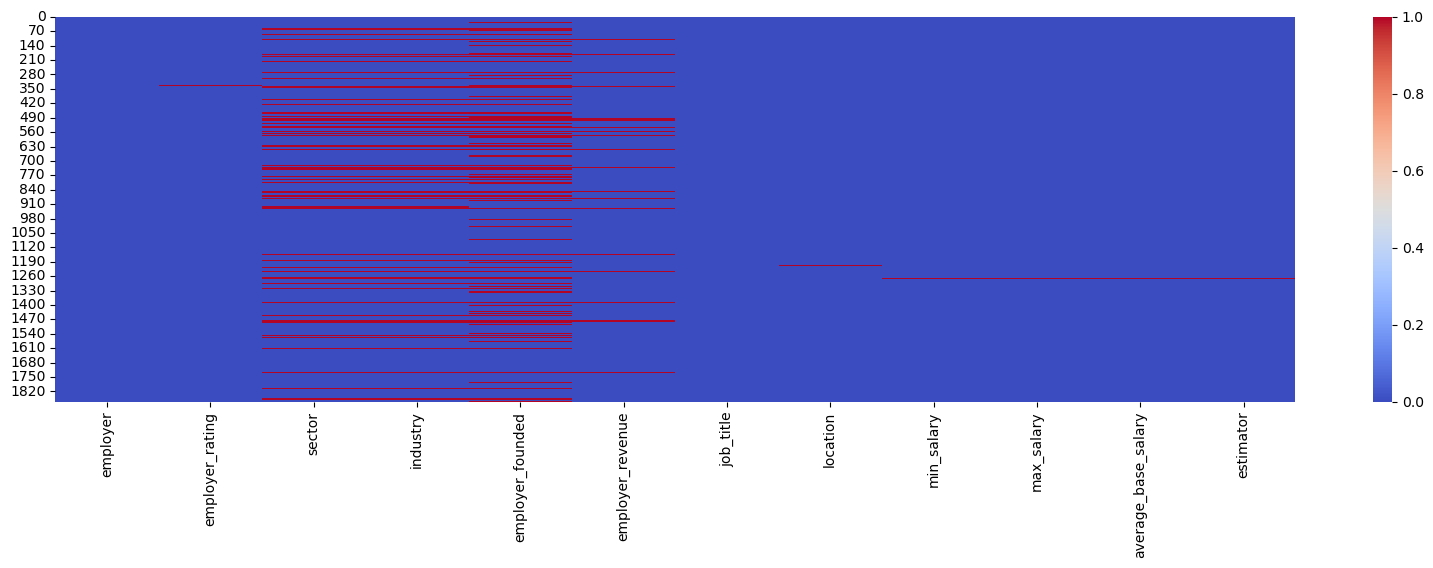

In [3]:
plt.figure(figsize=(20, 5))
sns.heatmap(df.isna(), cmap='coolwarm')

In [4]:
# nan_values
nan_values = {}

for feature in df.columns:
    nan_values[feature] = df[feature].isna().sum()

print(nan_values)

{'employer': 2, 'employer_rating': 3, 'sector': 315, 'industry': 315, 'employer_founded': 486, 'employer_revenue': 116, 'job_title': 0, 'location': 1, 'min_salary': 9, 'max_salary': 9, 'average_base_salary': 9, 'estimator': 9}


# 1.1. First 6 features

* 1. Employer

In [5]:
df['employer'].describe()

count      1869
unique     1205
top       Apple
freq         36
Name: employer, dtype: object

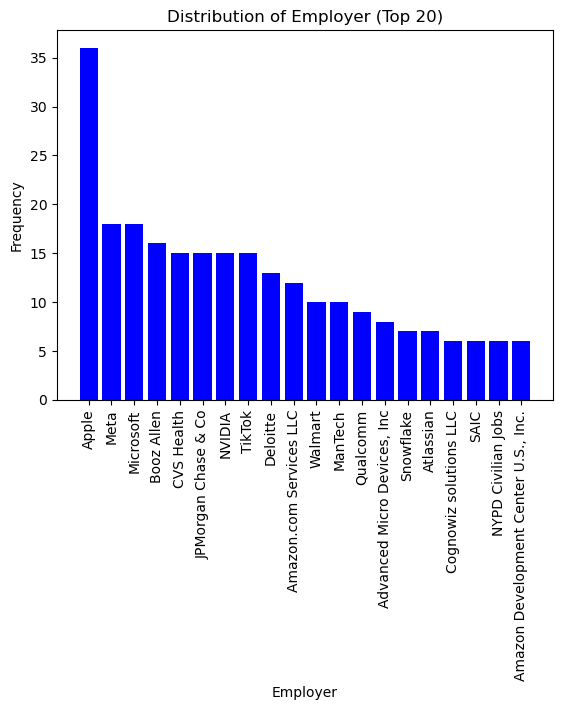

In [6]:
employer_counts = df['employer'].value_counts().head(20)  # Get the 20 most frequent values

# Plot the bar plot
plt.bar(employer_counts.index, employer_counts.values, color='blue')

# Set the plot title and labels
plt.title('Distribution of Employer (Top 20)')
plt.xlabel('Employer')
plt.ylabel('Frequency')

# Rotate x-axis labels if they are too long
plt.xticks(rotation=90)

# Show the plot
plt.show()

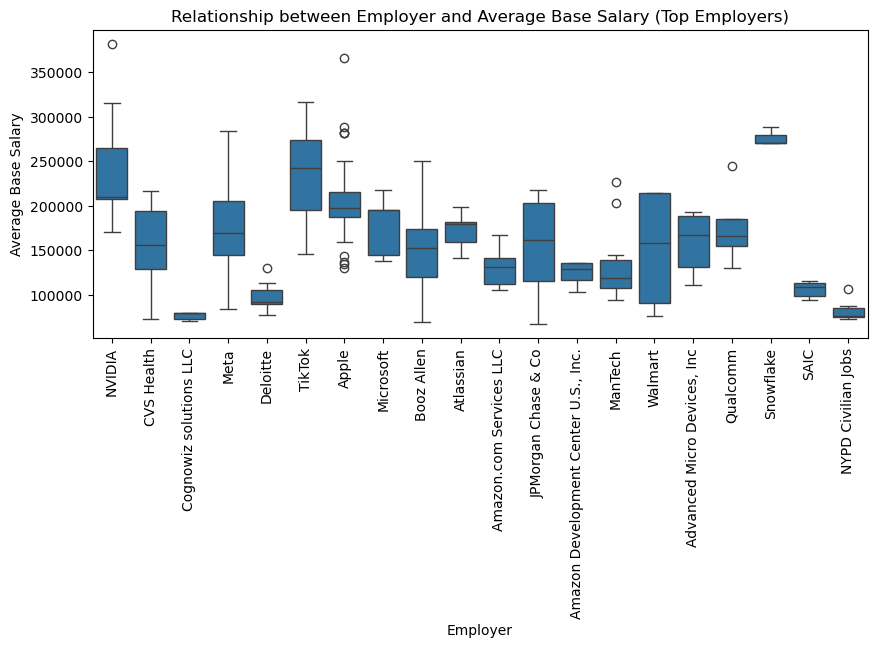

In [7]:
top_employers = df['employer'].value_counts().nlargest(20).index

# Filter the DataFrame based on the top employers
df_top_employers = df[df['employer'].isin(top_employers)]

# Create the box plot
plt.figure(figsize=(10, 4))
sns.boxplot(data=df_top_employers, x='employer', y='average_base_salary')

# Set the plot title and labels
plt.title('Relationship between Employer and Average Base Salary (Top Employers)')
plt.xlabel('Employer')
plt.ylabel('Average Base Salary')

# Rotate x-axis labels if they are too long
plt.xticks(rotation=90)

# Show the plot
plt.show()

* 2. Employer rating

In [8]:
df['employer_rating'].describe()

count    1868.000000
mean        3.886349
std         0.523340
min         1.000000
25%         3.600000
50%         3.900000
75%         4.200000
max         5.000000
Name: employer_rating, dtype: float64

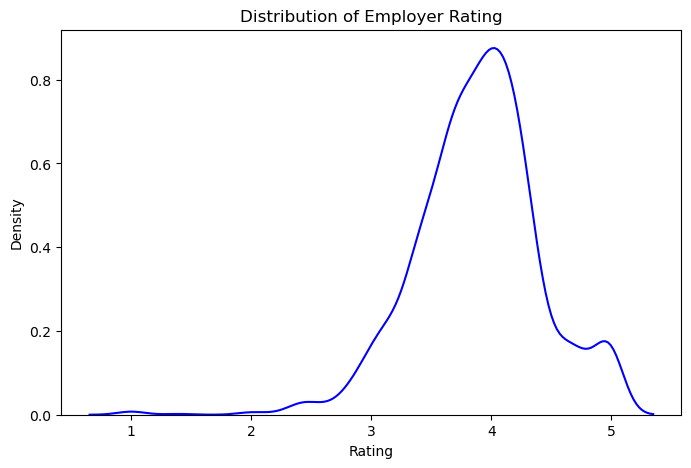

In [9]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df['employer_rating'], color='blue')

# Set the plot title and labels
plt.title('Distribution of Employer Rating')
plt.xlabel('Rating')
plt.ylabel('Density')

# Show the plot
plt.show()

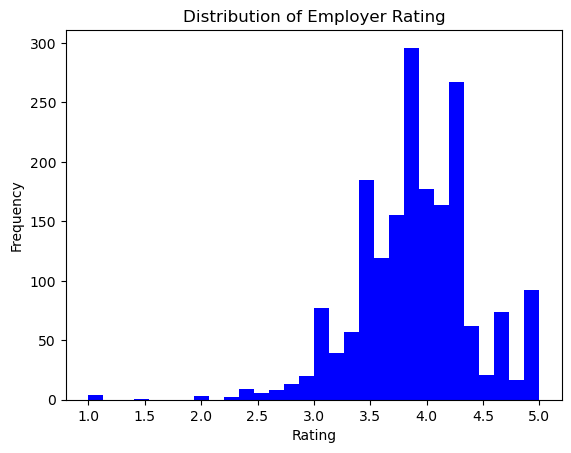

In [10]:
plt.hist(df['employer_rating'], bins=30, color='blue')

# Set the plot title and labels
plt.title('Distribution of Employer Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# Show the plot
plt.show()

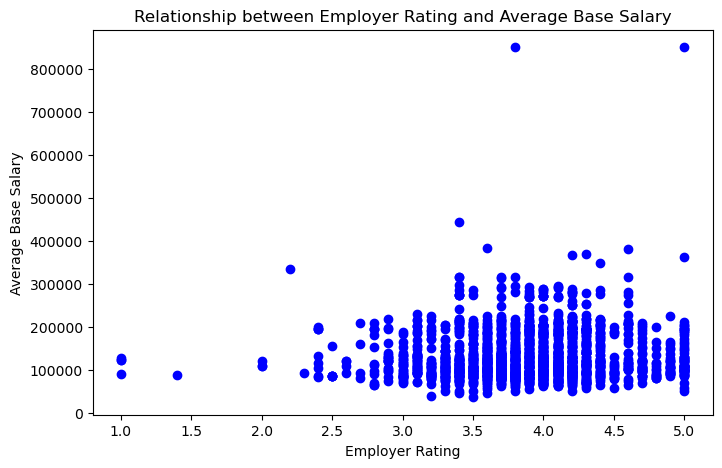

In [11]:
plt.figure(figsize=(8, 5))
plt.scatter(df['employer_rating'], df['average_base_salary'], color='blue')

# Set the plot title and labels
plt.title('Relationship between Employer Rating and Average Base Salary')
plt.xlabel('Employer Rating')
plt.ylabel('Average Base Salary')

# Show the plot
plt.show()

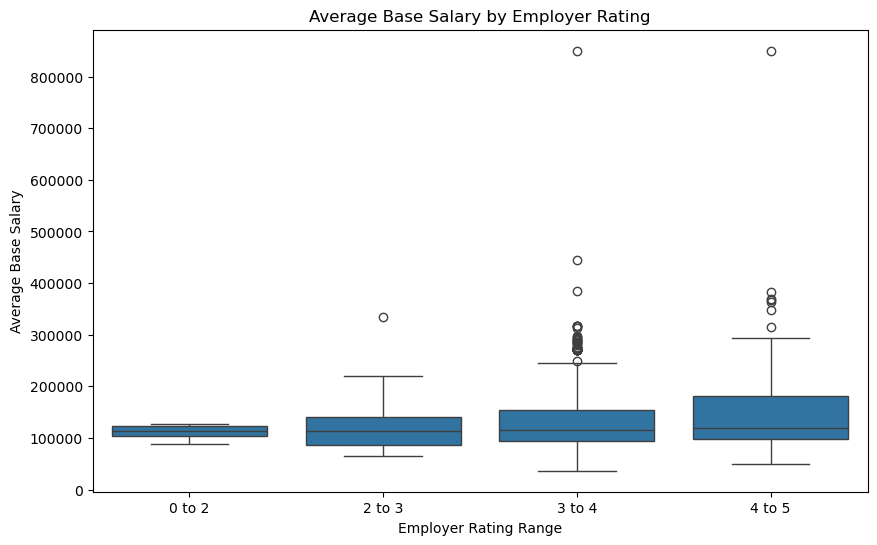

In [12]:
ranges = [(0, 2), (2, 3), (3, 4), (4, 5)]

# Create a new column 'rating_range' to categorize employer_rating into the defined ranges
df['rating_range'] = pd.cut(df['employer_rating'], bins=[r[0] for r in ranges] + [r[1] for r in ranges[-1:]], labels=[f'{r[0]} to {r[1]}' for r in ranges])

# Create the boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='rating_range', y='average_base_salary')

# Set the plot title and labels
plt.title('Average Base Salary by Employer Rating')
plt.xlabel('Employer Rating Range')
plt.ylabel('Average Base Salary')

# Show the plot
plt.show()

* 3. Sector

In [13]:
df['sector'].describe()

count                       1556
unique                        24
top       Information Technology
freq                         600
Name: sector, dtype: object

In [14]:
df['sector'].unique()

array(['Information Technology', 'Management & Consulting',
       'Financial Services', nan, 'Education', 'Media & Communication',
       'Energy, Mining & Utilities', 'Manufacturing', 'Healthcare',
       'Nonprofit & NGO', 'Transportation & Logistics',
       'Government & Public Administration', 'Restaurants & Food Service',
       'Human Resources & Staffing', 'Retail & Wholesale',
       'Hotels & Travel Accommodation', 'Aerospace & Defense', 'Legal',
       'Arts, Entertainment & Recreation', 'Personal Consumer Services',
       'Insurance', 'Pharmaceutical & Biotechnology',
       'Telecommunications',
       'Construction, Repair & Maintenance Services', 'Real Estate'],
      dtype=object)

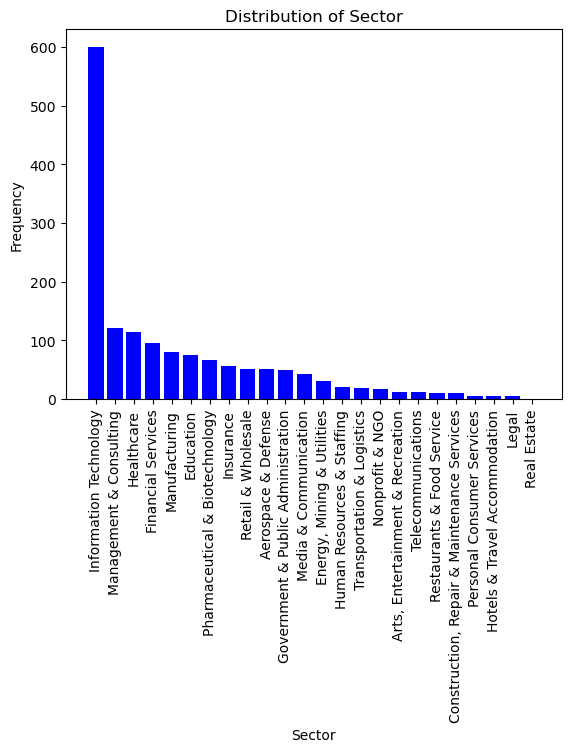

In [15]:
sector_counts = df['sector'].value_counts()

# Plot the bar plot
plt.bar(sector_counts.index, sector_counts.values, color='blue')

# Set the plot title and labels
plt.title('Distribution of Sector')
plt.xlabel('Sector')
plt.ylabel('Frequency')

# Rotate x-axis labels if they are too long
plt.xticks(rotation=90)

# Show the plot
plt.show()

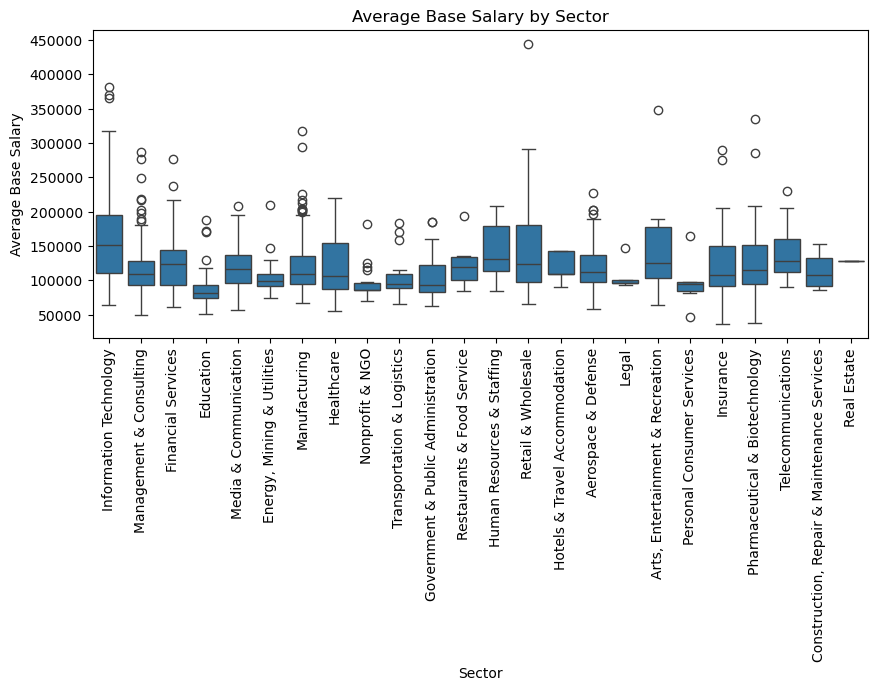

In [16]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x='sector', y='average_base_salary')

# Set the plot title and labels
plt.title('Average Base Salary by Sector')
plt.xlabel('Sector')
plt.ylabel('Average Base Salary')

# Rotate x-axis labels if they are too long
plt.xticks(rotation=90)

# Show the plot
plt.show()

* 4. Industry

In [17]:
df['industry'].describe()

count                              1556
unique                               81
top       Computer Hardware Development
freq                                177
Name: industry, dtype: object

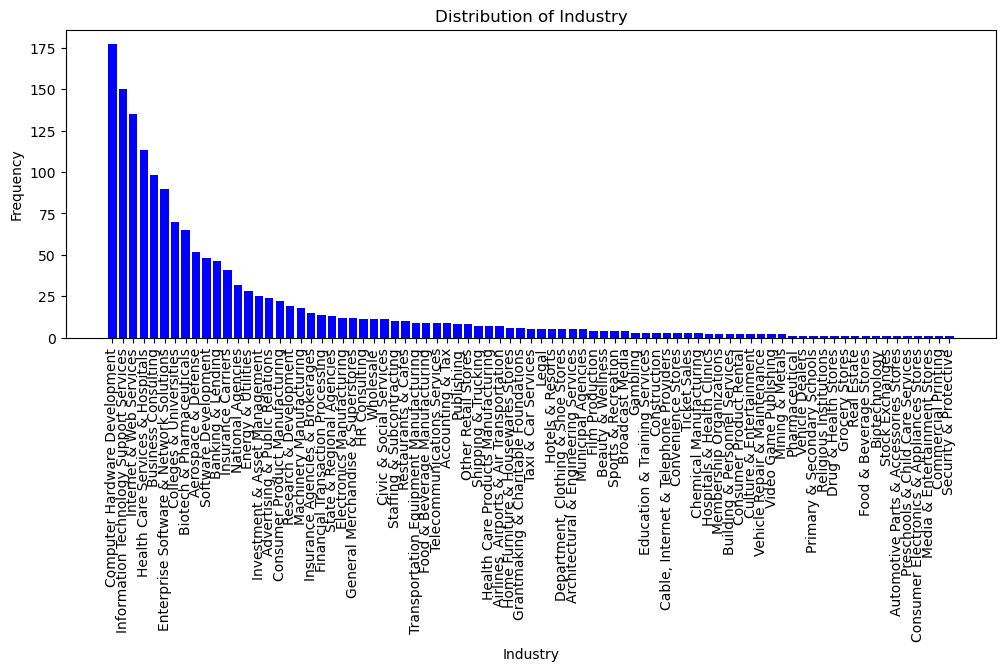

In [18]:
industry_counts = df['industry'].value_counts()

# Set the desired width and height of the figure
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the bar plot
ax.bar(industry_counts.index, industry_counts.values, color='blue')

# Set the plot title and labels
ax.set_title('Distribution of Industry')
ax.set_xlabel('Industry')
ax.set_ylabel('Frequency')

# Rotate x-axis labels if they are too long
plt.xticks(rotation=90)

# Show the plot
plt.show()

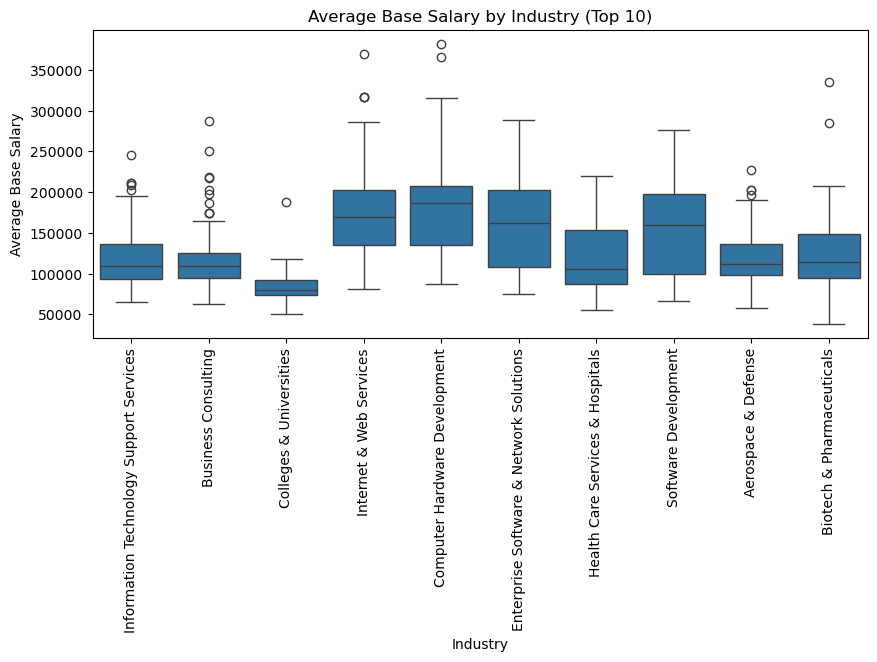

In [19]:
top_10_industries = df['industry'].value_counts().nlargest(10).index

# Filter the DataFrame for the top 10 industries
filtered_df = df[df['industry'].isin(top_10_industries)]

# Create the boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(data=filtered_df, x='industry', y='average_base_salary')

# Set the plot title and labels
plt.title('Average Base Salary by Industry (Top 10)')
plt.xlabel('Industry')
plt.ylabel('Average Base Salary')

# Rotate x-axis labels if they are too long
plt.xticks(rotation=90)

# Show the plot
plt.show()

* 5. Employer founded

In [20]:
df['employer_founded'].describe()

count    1385.000000
mean     1966.228881
std        56.959551
min      1625.000000
25%      1945.000000
50%      1986.000000
75%      2007.000000
max      2022.000000
Name: employer_founded, dtype: float64

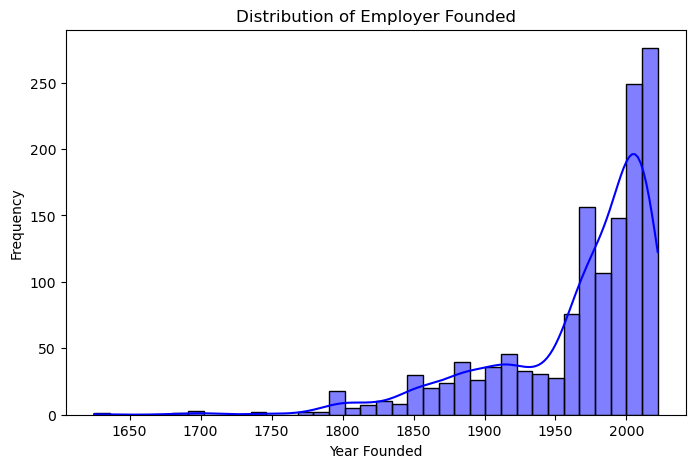

In [21]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='employer_founded', kde=True, color='blue')

# Set the plot title and labels
plt.title('Distribution of Employer Founded')
plt.xlabel('Year Founded')
plt.ylabel('Frequency')

# Show the plot
plt.show()

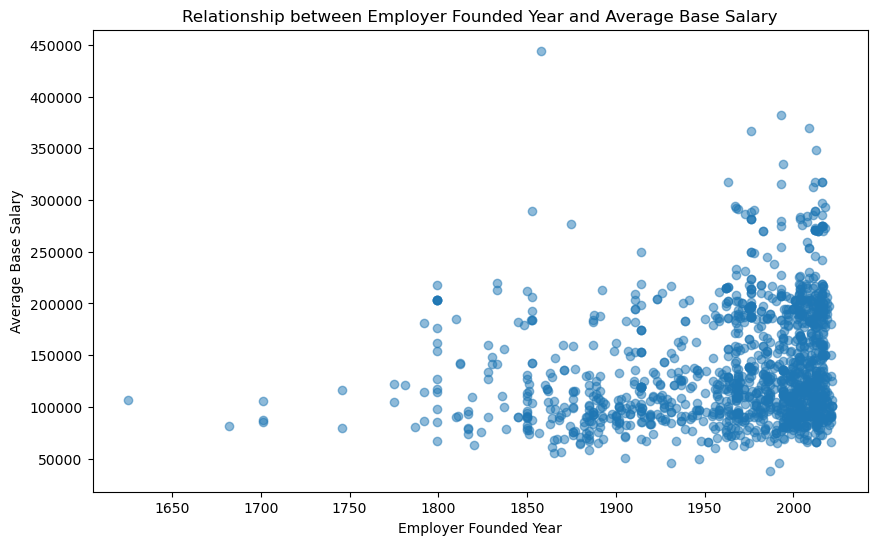

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(df['employer_founded'], df['average_base_salary'], alpha=0.5)

# Set the plot title and labels
plt.title('Relationship between Employer Founded Year and Average Base Salary')
plt.xlabel('Employer Founded Year')
plt.ylabel('Average Base Salary')

# Show the plot
plt.show()

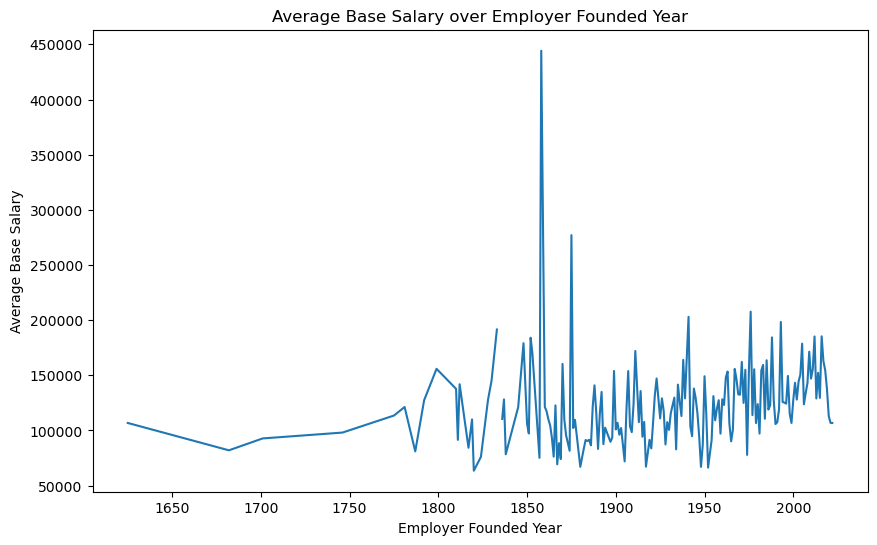

In [23]:
mean_salaries = df.groupby('employer_founded')['average_base_salary'].mean()

# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(mean_salaries.index, mean_salaries.values)

# Set the plot title and labels
plt.title('Average Base Salary over Employer Founded Year')
plt.xlabel('Employer Founded Year')
plt.ylabel('Average Base Salary')

# Show the plot
plt.show()

* 6. Revenue

In [24]:
df['employer_revenue'].describe()

count                         1755
unique                          10
top       Unknown / Non-Applicable
freq                           649
Name: employer_revenue, dtype: object

In [25]:
df['employer_revenue'].unique()

array(['$1 to $5 billion (USD)', '$500 million to $1 billion (USD)',
       '$5 to $25 million (USD)', 'Unknown / Non-Applicable',
       '$10+ billion (USD)', nan, '$100 to $500 million (USD)',
       '$5 to $10 billion (USD)', 'Less than $1 million (USD)',
       '$1 to $5 million (USD)', '$25 to $100 million (USD)'],
      dtype=object)

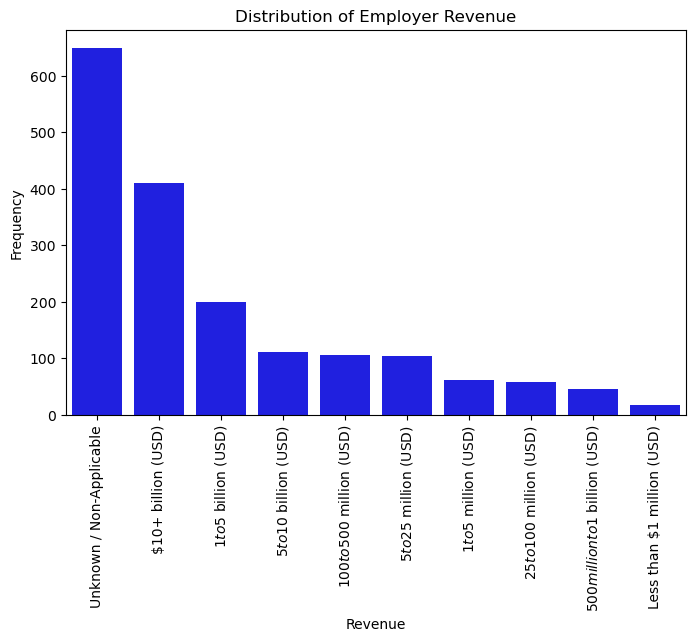

In [26]:
revenue_counts = df['employer_revenue'].value_counts()

# Plot the bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=revenue_counts.index, y=revenue_counts.values, color='blue')

# Set the plot title and labels
plt.title('Distribution of Employer Revenue')
plt.xlabel('Revenue')
plt.ylabel('Frequency')

# Rotate x-axis labels if they are too long
plt.xticks(rotation=90)

# Show the plot
plt.show()

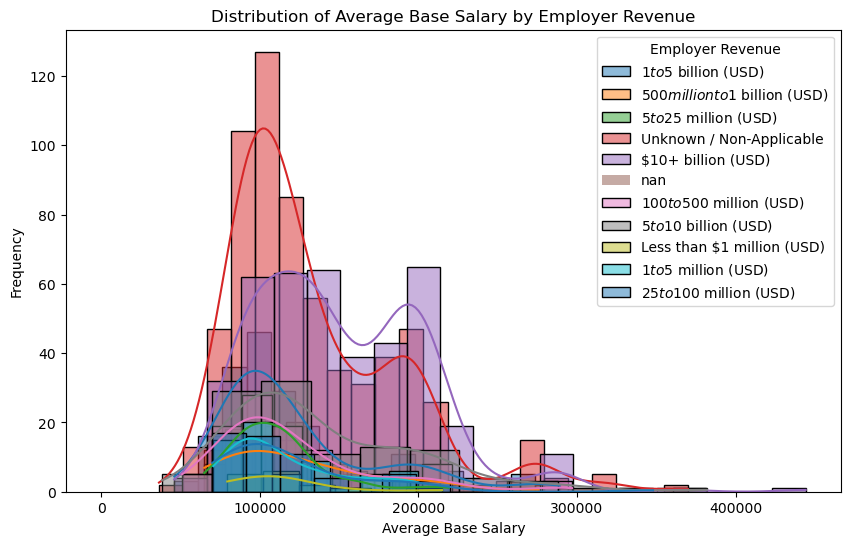

In [27]:
plt.figure(figsize=(10, 6))
for revenue_category in df['employer_revenue'].unique():
    sns.histplot(data=df[df['employer_revenue'] == revenue_category], x='average_base_salary', label=revenue_category, kde=True)

# Set the plot title and labels
plt.title('Distribution of Average Base Salary by Employer Revenue')
plt.xlabel('Average Base Salary')
plt.ylabel('Frequency')

# Show the legend
plt.legend(title='Employer Revenue')

# Show the plot
plt.show()

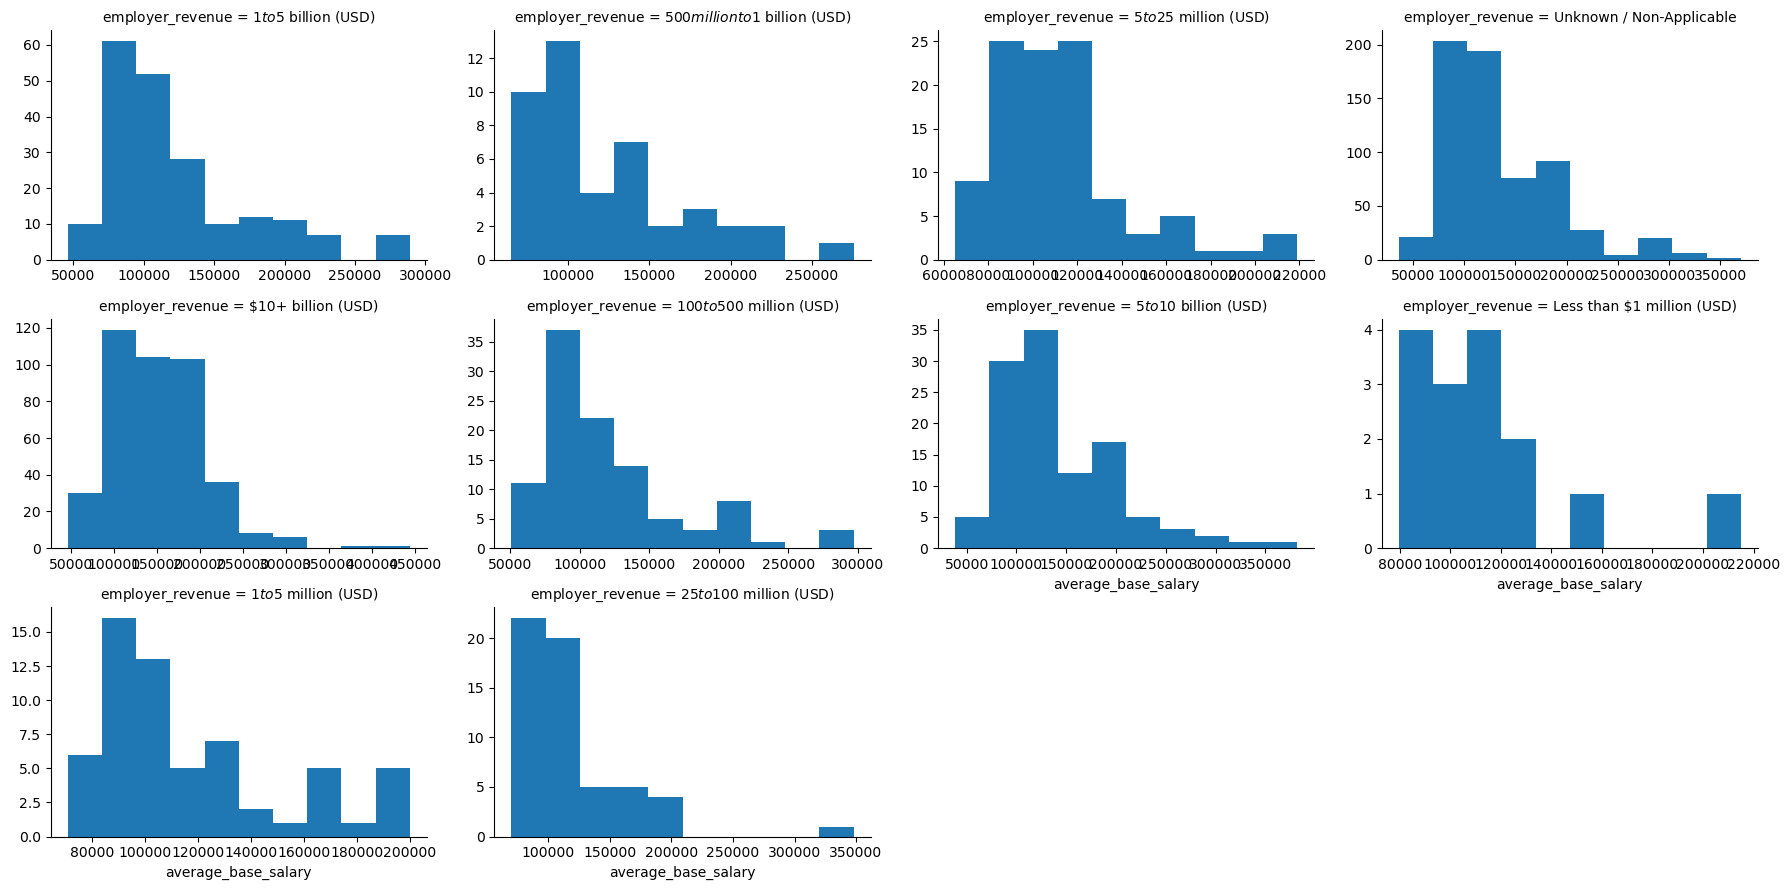

In [28]:
g = sns.FacetGrid(df, col="employer_revenue", col_wrap=4, sharex=False, sharey=False, aspect=1.5)  # You can adjust the aspect value as needed
g.map(plt.hist, 'average_base_salary')

plt.show()

# 1.2. Last 6 features

* 7. Job title

In [29]:
df['job_title'].describe()

count               1871
unique              1105
top       Data Scientist
freq                 359
Name: job_title, dtype: object

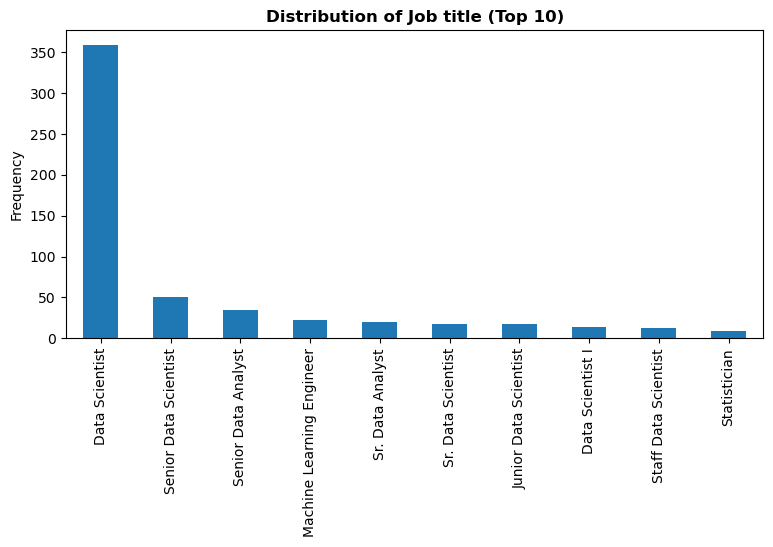

In [30]:
plt.figure(figsize=(9,4))
df['job_title'].value_counts().head(10).plot(kind='bar')
plt.title('Distribution of Job title (Top 10)', fontweight ='bold')
plt.xlabel('')
plt.ylabel('Frequency')
plt.show()

* 8. Location

In [31]:
df['location'].describe()

count       1870
unique       416
top       Remote
freq         156
Name: location, dtype: object

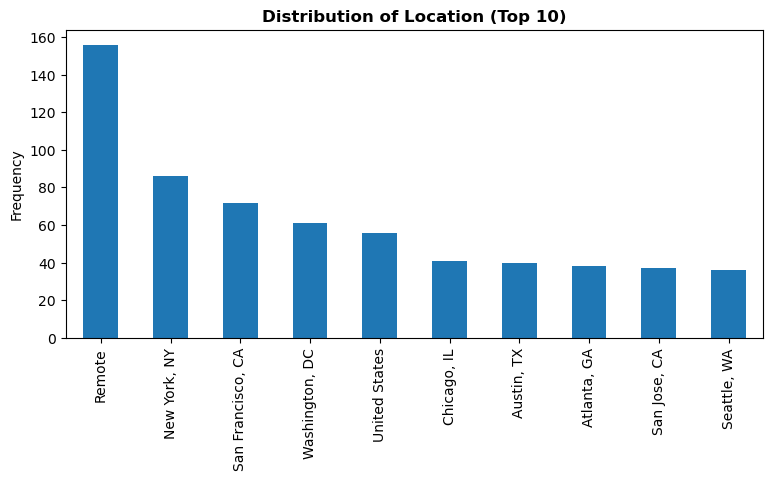

In [32]:
plt.figure(figsize=(9,4))
df['location'].value_counts().head(10).plot(kind='bar')
plt.title('Distribution of Location (Top 10)', fontweight ='bold')
plt.xlabel('')
plt.ylabel('Frequency')
plt.show()

In [33]:
# to do it later
# sns.boxplot(x='location', y='average_base_salary', data=df)
# plt.show()

* 9. Min_salary

In [34]:
df['min_salary'].describe()

count      1862.000000
mean     110759.421697
std       48090.480905
min       34560.000000
25%       79000.000000
50%      100000.000000
75%      135000.000000
max      800000.000000
Name: min_salary, dtype: float64

In [35]:
df['min_salary'].value_counts()

min_salary
100000.0    44
75000.0     42
80000.0     42
70000.0     39
90000.0     38
            ..
37000.0      1
46000.0      1
140160.0     1
154000.0     1
246000.0     1
Name: count, Length: 230, dtype: int64

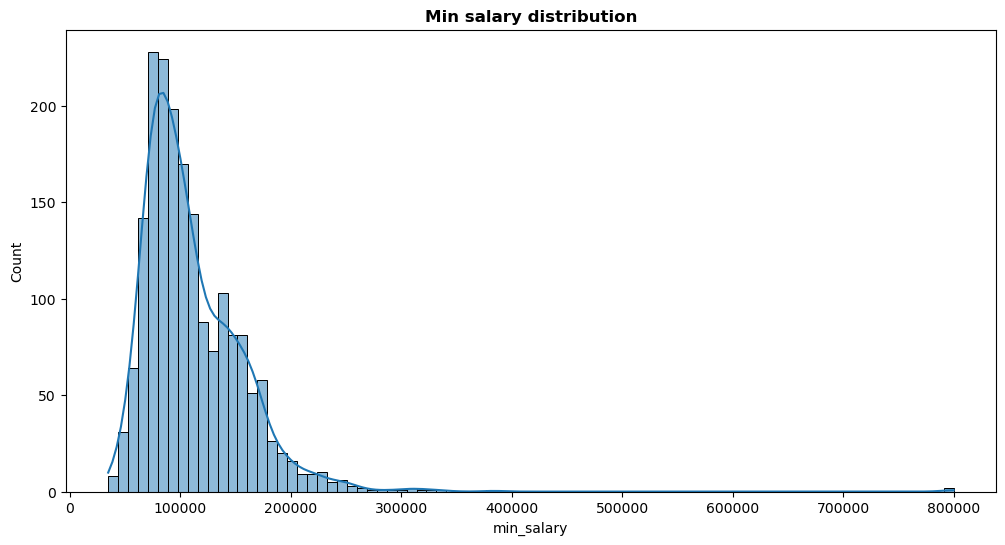

In [36]:
plt.figure(figsize=(12,6))
sns.histplot(df['min_salary'], kde=True)
plt.title('Min salary distribution', fontweight='bold')
plt.show()

In [37]:
# to do it later
# sns.boxplot(x='min_salary', y='average_base_salary', data=df)
# plt.show()

* 10. Max_salary

In [38]:
df['max_salary'].describe()

count      1862.000000
mean     157080.325671
std       69061.285157
min       38400.000000
25%      112000.000000
50%      135000.000000
75%      187000.000000
max      900000.000000
Name: max_salary, dtype: float64

In [39]:
df['max_salary'].value_counts()

max_salary
130000.0    42
120000.0    39
100000.0    31
140000.0    30
117000.0    29
            ..
59000.0      1
64000.0      1
60000.0      1
262000.0     1
405000.0     1
Name: count, Length: 303, dtype: int64

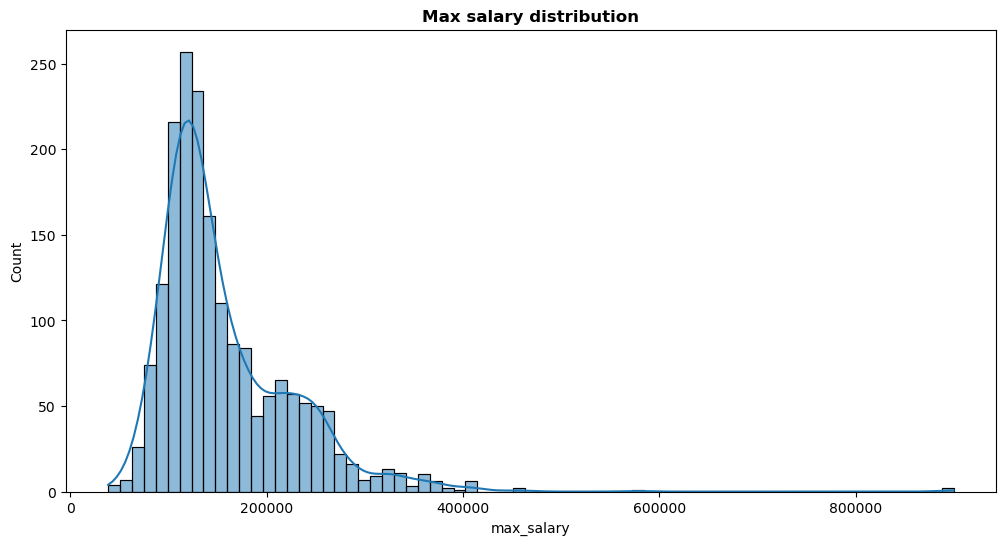

In [40]:
plt.figure(figsize=(12,6))
sns.histplot(df['max_salary'], kde=True)
plt.title('Max salary distribution', fontweight='bold')
plt.show()

* 11. Average_base_salary

In [41]:
df['average_base_salary'].describe()

count      1862.000000
mean     133130.280773
std       57214.758129
min       36480.000000
25%       94551.750000
50%      117251.000000
75%      162037.500000
max      850000.000000
Name: average_base_salary, dtype: float64

In [42]:
df['average_base_salary'].value_counts()

average_base_salary
120000.0    22
195000.0    18
115000.0    16
85000.0     13
95000.0     12
            ..
126174.0     1
122087.0     1
100800.0     1
75180.0      1
272520.0     1
Name: count, Length: 1286, dtype: int64

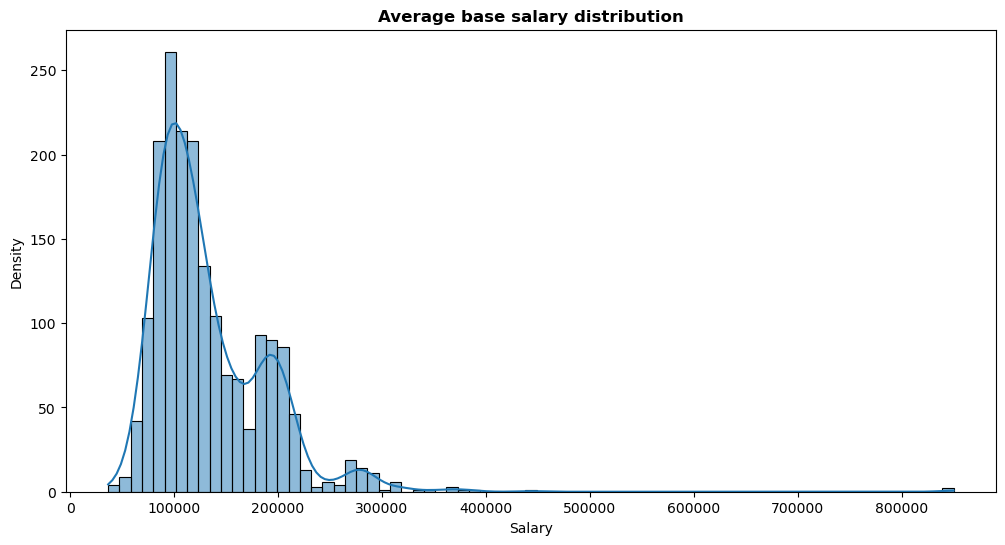

In [43]:
plt.figure(figsize=(12,6))
sns.histplot(df['average_base_salary'], kde=True)
plt.title('Average base salary distribution', fontweight='bold')
plt.xlabel('Salary')
plt.ylabel('Density')
plt.show()

* 12. Estimator

In [44]:
df['estimator'].describe()

count         1862
unique           2
top       Employer
freq          1050
Name: estimator, dtype: object

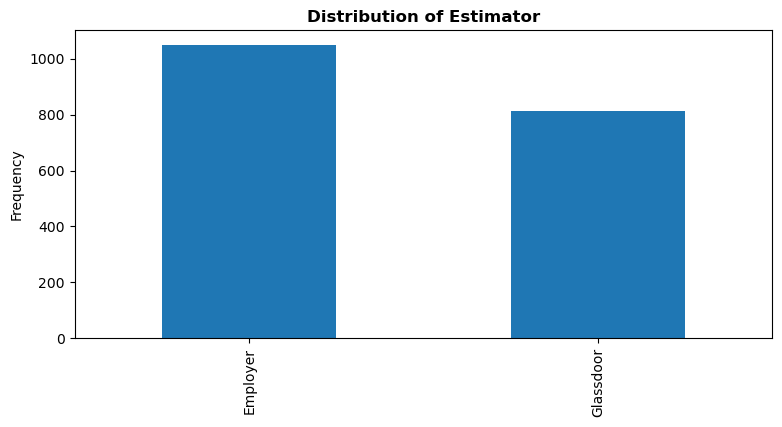

In [45]:
plt.figure(figsize=(9,4))
df['estimator'].value_counts().plot(kind='bar')
plt.title('Distribution of Estimator', fontweight ='bold')
plt.xlabel('')
plt.ylabel('Frequency')
plt.show()

# 2. Handling NaNs

In [46]:
# check nan_values
nan_values = {}

for feature in df.columns:
    nan_values[feature] = df[feature].isna().sum()

print(nan_values)

{'employer': 2, 'employer_rating': 3, 'sector': 315, 'industry': 315, 'employer_founded': 486, 'employer_revenue': 116, 'job_title': 0, 'location': 1, 'min_salary': 9, 'max_salary': 9, 'average_base_salary': 9, 'estimator': 9, 'rating_range': 3}


In [47]:
# employer_rating
mean_employer_rating = df['employer_rating'].mean()
df['employer_rating'].fillna(mean_employer_rating, inplace=True)

In [48]:
# sector, industry
df['sector'].fillna('Unknown', inplace=True)
df['industry'].fillna('Unknown', inplace=True)

In [49]:
# employer_founded
median_employer_founded = df['employer_founded'].median()
df['employer_founded'].fillna(median_employer_founded, inplace=True)

In [50]:
# employer_revenue
df['employer_revenue'].fillna("Unknown / Non-Applicable", inplace=True)

In [51]:
# location
df['location'].fillna("Remote", inplace=True)

In [52]:
# min_salary
min_salary_median_value = df['min_salary'].median()
df['min_salary'].fillna(min_salary_median_value, inplace=True)

In [53]:
# max_salary
max_salary_median_value = df['max_salary'].median()
df['max_salary'].fillna(max_salary_median_value, inplace=True)

In [54]:
# average_base_salary
avg_base_salary_median_value = df['average_base_salary'].median()
df['average_base_salary'].fillna(avg_base_salary_median_value, inplace=True)

In [55]:
# estimator
df['estimator'].fillna("Employer", inplace=True)

In [56]:
# employer
df['employer'].fillna("Unknown", inplace=True)

In [57]:
# rating_range
df['rating_range'].fillna("3 to 4", inplace=True)

In [58]:
# check nan_values
nan_values = {}

for feature in df.columns:
    nan_values[feature] = df[feature].isna().sum()

print(nan_values)

{'employer': 0, 'employer_rating': 0, 'sector': 0, 'industry': 0, 'employer_founded': 0, 'employer_revenue': 0, 'job_title': 0, 'location': 0, 'min_salary': 0, 'max_salary': 0, 'average_base_salary': 0, 'estimator': 0, 'rating_range': 0}


# 3. Make a column job_title look more jeneral

In [59]:
# convert to lowercase
df['job_title'] = df['job_title'].str.lower()

In [60]:
words_to_remove = ['senior', 'sr.', 'sr', 'junior', 'jr', 'jr.', 'staff', 'lead', 'principal', 'associate', 'director', 'advanced', 'trainer']
pattern = '|'.join(words_to_remove)

# Remove the specified words from the column using regular expressions
df['job_title'] = df['job_title'].str.replace(pattern, '', regex=True)

# Remove spaces, dots, and commas at the beginning and end of a line
df['job_title'] = df['job_title'].str.replace(r'^[\s.,]*|\s*[.,]*\s*$', '', regex=True)
# Search for all variants of 'data scientist', which can be followed by spaces, dashes or closing brackets, and replaces them with 'data scientist'
df['job_title'] = df['job_title'].str.replace(r'\b(data\s+scientist[\s,\)-]*).*', 'data scientist', regex=True)
# Remove brackets and their contents from the column
df['job_title'] = df['job_title'].str.replace(r'\(.*\)', '', regex=True)
# Replace extra spaces in the column
df['job_title'] = df['job_title'].str.replace(r'\s+', ' ', regex=True)

# Remove spaces at the beginning and end of lines
df['job_title'] = df['job_title'].str.strip()

In [61]:
df['job_title'].value_counts().head(50)

job_title
data scientist                                            823
data analyst                                               70
machine learning engineer                                  51
statistician                                               11
applied scientist                                           9
data engineer                                               8
business data analyst                                       8
ai/ml engineer                                              8
statistical analyst                                         7
ai engineer                                                 7
data science manager                                        6
research data scientist                                     6
data science                                                6
clinical data analyst                                       5
statistical programmer                                      5
data science analyst                                        

In [62]:
df['job_title'].unique()

array(['data scientist', 'data analyst',
       'bioinformatics scientist/ data scientist',
       'ecommerce data scientist', 'machine learning engineer',
       'data science/ data scientist', 'scientist, data science - hybrid',
       'data analyst/scientist', 'autonomy engineer - deep learning',
       'ai/ml engineer', 'research data scientist', 'mid data scientist',
       'consultant in strategy & data science - new york - may 2024',
       'business data analyst', 'marketing data scientist',
       'data analyst / data scientist', 'aws data engineer',
       'strategic finance, data scientist', 'partner decision scientist',
       'data engineer / data scientist', 'data analyst i - pricing',
       'clinical data analyst', 'ai data analyst',
       'healthcare data scientist', 'data and machine learning scientist',
       'claim data scientist', 'early career data scientist',
       'urbn data scientist', 'entry-level data scientist',
       'machine learning data scientist', '

In [63]:
# dictionary to use for further categorization
job_titles = {
    'Data Scientist':
    ['data scientist', 'bioinformatics scientist/ data scientist', 'ecommerce data scientist', 'data science/ data scientist', 'scientist, data science - hybrid', 'data analyst/scientist', 'research data scientist', 'mid data scientist', 'consultant in strategy & data science - new york - may 2024', 'marketing data scientist', 'strategic finance, data scientist', 'partner decision scientist', 'healthcare data scientist', 'claim data scientist', 'early career data scientist', 'urbn data scientist', 'entry-level data scientist', 'machine learning data scientist', 'supply chain data scientist', 'applied scientist', 'talent acquisition partner - engineering & data science', 'project engineer data manager data scientist', 'strategic workforce planning data scientist', 'information operations data scientist', 'information security data scientist', 'measurement & analytics, data scientist', 'osint data scientist', 'quality data scientist', 'process data scientist', 'vie - data scientist', 'scientific programmer/data scientist', 'rwd data scientist', 'genai data scientist', 'load forecast data scientist', 'spectroscopy data scientist', 'remote - fraud data scientist', 'orion navigation data scientist', 'postdoctoral research fellow- data scientist', 'data engineer scientist', 'college graduate - data science', '24-50 - hydrometeorology data scientist', 'materials scientist - data science', 'product data scientist', 'vp - data scientist', 'data science engineer (data scientist', 'physical scientist - data assimilation', 'bioinformatician / data scientist', 'geospatial data scientist', 'machine learning scientist', 'research data scientist', 'biostatistician data scientist', 'ml data scientist', 'people data scientist', 'genomics data scientist', 'public health data scientist', 'air quality data scientist', 'airborne data scientist', 'consultant - data scientist', 'media analytics data scientist', 'hockey data scientist', 'scientist, data review', 'software engineer and data scientist', 'data science analyst', 'expert ai/ml data scientist', 'clinical data scientist', 'data analytics specialist/clinical data scientist', 'decision scientist - metaverse', 'astronomical data scientist', 'full performance data analyst/scientist', 'planning data scientist', 'security engineer - data scientist', 'biomedical informatics data scientist', 'hurricane data assimilation scientist', 'experienced data scientist', 'hp083 data curation scientist', 'ai / ml / data science engineer - usa', 'early career environmental scientist data manager', 'applied scientist i', 'mid level data scientist', 'tiktok shop - us data scientist', 'postdoctoral scientist - r&d data science analytics & insights', 'decision scientist - dispute automation', 'data science', 'research scientist and data analyst', 'evaluation & data scientist', 'apprentice program - data science', 'of data science – part time / contract', 'capital markets quantitative data analyst', 'hr data analyst', 'co-op, machine learning data scientist', 'cleared data scientist', 'ai data scientist', 'statistician / data scientist', 'ai technical consultant', 'apprentice program - data science', ', data scientist', 'specialist, data science', 'data strategy program manager, vp', 'vp, compliance officer - ai/ml data scientist', 'generative ai strategist, generative ai innovation center', 'decision scientist - specialty pharmacy growth', 'clinical statistical programmer - remote',
     'intermediate data scientist', 'journeyman data scientist', 'growth data scientist', 'manager-data science', 'predictive modeling engineer - people processes', 'applied ai/ml - hr data and analytics - executive', 'research analyst', 'svp, chief architect of data technology', 'generative ai strategist', 'ai ml integration specialist', 'medicare stars data science analyst- hybrid- cigna healthcare- nc, tx, pa, ct, mo, tn', 'marine fisheries data analyst - fish & wildlife research scientist 1 - non-permanent - *02734-24', 'cancer data science program manager - rogel cancer center', 'statistician, modeling', 'qualitative research scientist and qualitative data analyst', 'post-doctoral scientist, data science rwe analytics', 'data science analyst - ihm', 'engineering data scientist', 'marketing data science', 'security data analyst', 'machine learning engineer, support products', 'marketing data science', 'engineering data scientist', 'security data analyst', 'machine learning engineer, support products', 'ai/ml image processing engineer', 'data analyst/scientist - ts/sci polygraph required', 'data science consultant', 'data visualization developer - solution specialist', 'scientist, data reviewer', 'ai business analyst', 'claims research/ data analyst', 'crime data analyst', 'data science summer', 'actuarial data scientist', 'risk adjustment data analyst', 'bioinformatics data scientist', 'postdoctoral research : fire weather data scientist', 'accelerated learning data scientist', 'research assistant/analyst, data science', 'data analyst - ai', 'data analyst- ediscovery manager', 'analyst/statistician', 'business intelligence data analyst', 'data analyst, department of oncology, dell medical school', 'statistician -as24-02516', 'nonproliferation data science postdoctoral research', 'research statistician', 'software engineer, ai/ml', 'ai/ml consultant - w2 role', 'data extraction analyst', 'business intelligence engineer', 'master data analyst', 'analyst, data science and analytics', 'statistics and data science grader', 'program manager ii, research data systems - tisch cancer institute', 'product security engineer-artificial intelligence/machine learning', 'twdb - 24-50 - hydrometeorology data scientist', 'marketing data analyst', 'postdoctoral research - ai/machine learning for illicit drug identification', 'analyst, marketing analytics', 'data science advisor', 'data science - b2b marketing', 'data analyst, forecasting & modeling', 'data science & analytics', 'researcher – high performance computing, machine learning systems, programming languages, formal methods – microsoft research', 'data & ml scientist', 'research scientist, machine learning and eye tracking', 'data science and analytics', 'hardware insights machine learning data scientist', 'machine learning scientist / machine learning manager', 'researcher – deep learning – microsoft research', 'machine learning researcher, carbon neutrality', 'c++ research engineer: databases & ai startup', 'applied scientist, conversational intelligence', 'applied scientist, artificial intelligence', 'machine learning engineer – foundation models – microsoft research',
     'data strategist - irad', 'research scientist, natural language', 'vp & data scientist', 'manager ip sales north america, computer graphics & machine learning', 'ai research tech , large language models', 'machine learning systems engineer, finetuning', 'executive , artificial intelligence', 'aiml - machine learning researcher, foundation models', 'data science - monetization infrastructure', 'ai/ml engineer', 'data and machine learning scientist', 'urbn data scientist', 'mgr, data science', 'decisions scientist', 'scientist, data automation', 'data science: opportunities for phd graduates', 'data assimilation scientist - hurricane', 'data science strategy', 'research data scientist', 'svp data science', 'natural language processing research assistant', 'data science co-op', 'data annotation - safety tasks / content moderation', '?data scientist', 'data annotation specialist', 'data/machine learning engineer', 'nlp developer', 'scientist i, data sciences', 'biomedical data scientist', 'co-op, flight operations learning - data visualization', 'data science developer', 'artificial intelligence engineer', 'artificial intelligence strategist', 'artificial intelligence subject matter expert', 'of ai strategy', 'hc data analyst -', 'data visualization & analysis sme', 'ai advise specialist er', 'spanish data natural language understanding', 'software engineer, deep learning', 'big data mining and artificial intelligence in the era of large astronomical surveys', 'data center engineer', 'applied scientist ii', 'of strategic data and analytics', 'data science business analyst', 'healthcare - ai/ml full stack engineer - w2 only', 'of product management, apps', 'data science analyst', 'ent-data scientist', 'data modeler', 'deep learning architect, generative ai innovation center', 'artificial intelligence technical consultant', 'applied scientist - wwbpr analytics', 'software engineer, machine learning infrastructure and quality', 'deep learning field engineer', 'vice president, health policy - evaluation, economics and predictive modeling -', 'applied scientist ii, next gen developer experience', 'aiml - machine learning manager, siri understanding', 'software development engineer ii, gen ai', 'digital contact solutions and conversational ai- manager', 'mfg data sw development engineer', 'data science analyst - cdh - remote', 'full stack developer', 'artificial intelligence architect', 'data architect', 'multiple opportunities -- aimss', 'software development engineer ii, ai/ml adc', 'manager, data governance', 'research data analyst', 'siteops data center operations engineer', 'machine learning engineer - health strategic initiative', 'data analyst - quality-1', 'gen ai software developer', 'specialist-data scientist', 'scientist ii, data sciences', 'tech data scientist',
     'csdo data scientist', 'consultant-data science', 'information technology specialist (data scientist', 'applied scientist ii, generative ai innovation center', 'applied scientist iii, next gen developer experience', 'manager, enterprise generative artificial intelligence', 'mts - deep learning software engineer - ai models', 'data owner - voice operations', 'aiml - machine learning engineer , siri and information intelligence', 'data science & machine learning', 'finance & data analyst', 'counsel, data privacy & security', 'r&d - data center systems architect -', 'operations research engineering , abacus.ai, inc., san francisco, ca', 'data science manager', 'technical program manager – data science', 'applied scientist - speech', 'production systems engineer, fleet ai systems', 'software development/ai specialist', 'data analyst i, ii, or , system reliability', 'data cloud solutions', 'applied scientist ii, aft ai, amazon fulfillment technologies', 'data analytics manager - division of general internal medicine', 'artificial intelligence systems/tools engineer/administrator iii', 'machine learning engineer - analytics and core data management', 'computer science, software engineer', 'consulting software engineer data science', 'machine learning engineer, tiktok ads creative & ecosystem', 'ai engineer - hybrid', 'artificial intelligence engineer', 'partner development manager, phdata', 'business modeling - applied ai ml', 'of artificial intelligence applications', '/ data labeler', 'computational biologist/ machine learning scientist', 'credit model development analyst', 'ai manager', 'inspector general career field - 2024 dod artificial intelligence, cybersecurity & in', 'decision scientist', 'project manager/ data analyst', 'software engineer, query execution', 'inspector general career field - 2024 dod artificial intelligence, cybersecurity', 'deep learning engineer for camera-lidar based multimodal perception', 'manager, data science, ww returns & recommerce - ncrc', 'applied ai/ml - hr data and analytics - executive', '/ data scientist', 'product manager- ai software', 'health care data analyst - delta dental of ma', 'project engineer - automation autonomy and artificial intelligence', 'artificial intelligence technical program manager - silicon design', 'go to market specialist – artificial intelligence', 'applied scientist, reinforcement learning, supply chain optimization technologies', 'distinguished member technical - storage artificial intelligence architect', 'medicare stars data science analyst- hybrid- cigna healthcare- nc, tx, pa, ct, mo, tn', 'ai software engineer', 'inspector general career field - 2024 dod artificial intelligence, cybersecurity & informa',
     'data governance', 'data science - promotions', 'post-doctoral scientist, data science rwe analytics', 'data science engineer', 'manager - data science''site reliability engineer, ai infrastructure & observability', 'payment policy analytics', 'military fellowship-engineer-data science', '– business intelligence & analytics', 'data science analyst - ihm', 'aiml - machine learning manager, ml hardware/software co-design, machine learning platform & infrastructure', '- data science st. louis', 'corporate vice president, data scientist', 'artificial intelligence', 'developer/statistician', 'energy policy & data analyst', 'ai soc chip', 'data and analytics developer - concord, ca', 'ai automation consultant', 'computational scientist assistant -generative ai and deep learning', 'ai business systems analyst', 'artificial intelligence for planetary science discovery in legacy data', 'ai training for mathematics/statistics experts', 'data discovery and enrichment expert i', 'research ii - statistical analyst', 'business analyst - ai', 'data visualization powerbi developer', 'data analyst - corporate planning', 'global account data analyst', 'mathematics and statistics/data or computer science nte 15 weeks', 'healthcare data analyst or healthcare data analyst, analytics hub', 'data science - developmental', 'data visualization developer', 'data technologist', 'scientist i', 'data management analyst', 'endowed of artificial intelligence and computing', 'training and placement in gen ai', 'it pmo analyst', 'machine learning operations manager wfh', 'product analyst, growth', 'assessors office - rousseau centre - data analyst', 'voting rights data analyst', 'postdoctoral scientist - zhang lab - division of artificial intelligence in medicine', 'data discovery and enrichment', 'gosvea-0101 ai development engineer', 'auditor - data and ai', 'data visualization specialist', 'applied statistician', 'analyst ii - data science', 'dhts it analyst - data engineer', 'ai/ml developer', 'supply chain data analyst', 'training and placement for generative ai engineer', 'workforce management data analyst', 'data manager-ob/gyn-13120-001', 'information technology analyst - hybrid', 'manager data discovery and enrichment', 'mathematician i austin, tx or las vegas, nv', 'talent & data analyst', 'software engineer, ai/ml', 'data analyst – infrastructure security', 'epidemiologist', 'generative ai solutions developer', 'sun data analyst', 'postdoctoral - single- cell and data science', 'epidemiologist 2', 'data analyst - research analysis specialist', 'college advisor', 'postdoctoral research - ai/machine learning for illicit drug identification', 'product specialist', 'mathematician 2', 'systems analyst/data science team', 'business data steward', 'research in machine learning for pollinator behaviour analysis', 'digital data analyst, business intelligence', 'dea compliance data analyst', 'research scientist, scientific data management',
     'data science advisor - marketing', 'data manager - neurology', 'manager - data science', 'manager of data science', 'statistical programmer analyst', 'of data science', 'manager, data science', 'new w2 contract job role: engineer', 'applied research scientist - 3d reconstruction & deep learning', 'manager decision science, retail testing analytics', 'technologist, generative ai', 'architect - machine learning', 'technical program manager - machine learning platform', 'process data scientist', 'product manager - machine learning', 'data science & analytics', 'distinguished, statistical programming', 'product manager - apm/ai', 'data requirements manager', '/ applied scientist - causal inference & experimentation', 'manager & data scientist', 'product manager', 'portfolio , statistical programming', 'manager and data scientist', 'ml/ai data scientist', 'head of machine learning', 'research engineer, generative ai', 'machine learning engineering', 'software engineer - ai specialist', '#032 - data scientist', 'artificial intelligence platform architect', 'backend engineer', 'legal counsel, data protection - commercial legal', 'artificial intelligence software engineer', 'vp of data science', 'artificial intelligence product management', 'of machine learning', 'expert manager, machine learning engineer', 'research scientist, natural language', '/ machine learning engineer - automl', 'vice president, data science - finance and actuarial', 'svp, enterprise data analytics and technology', 'software engineer - trust center', 'tech machine learning ops, global', 'data center validation engineer', 'tech manager - code ai/gpt', 'applied scientist/tech , large language model - tiktok privacy', 'aiml - ml engineer/architect, natural language team, siri & information intelligence', 'vice president, data science & analytics', 'solutions architect', 'engineer, ai/ml software compiler', 'aiml - data infrastructure software engineer, machine learning platform and technology', 'urbn  data scientist', 'research  data scientist', 'artificial intelligence strategist', 'healthcare - ai/ml full stack engineer - w2 only', 'data science analyst', 'applied scientist - wwbpr analytics', 'tech data scientist', 'data owner - voice operations', 'machine learning scientist - natural language processing - vice president - machine learning center of excellence', 'artificial intelligence systems/tools engineer/administrator iii', 'machine learning engineer - analytics and core data management', 'artificial intelligence engineer', 'inspector general career field - 2024 dod artificial intelligence, cybersecurity & in', 'project manager/ data analyst', 'applied ai/ml - hr data and analytics - executive', '/ data scientist', 'go to market specialist – artificial intelligence', 'distinguished member technical - storage artificial intelligence architect', 'medicare stars data science analyst- hybrid- cigna healthcare- nc, tx, pa, ct, mo, tn', 'inspector general career field - 2024 dod artificial intelligence, cybersecurity & informa'],
    
    'Data Analyst':
    ['data analyst', 'data analyst/scientist', 'business data analyst', 'revenue data analyst', 'analyst-mathematician', 'systems & data analyst', 'of business intelligence and data analytics', 'grc business data analyst', 'developer, business data analyst', 'data analyst / data scientist', 'data analyst i - pricing', 'clinical data analyst', 'ai data analyst', 'data mining analyst', 'data analyst/data scientist', 'data modeler/data analyst', 'data science analyst ne - him -temporary - remote', 'data review scientist 1', 'academic data analyst', 'data visualization/data analyst specialist', 'data analyst, risk adjustment', 'data analyst, finance', 'data analyst – store inventory', 'research scientist and data analyst', 'of data science – part time / contract', 'capital markets quantitative data analyst', 'hr data analyst', 'ai product analyst', 'data analyst: big data analytics platform, saas & 100% remote', 'data analyst, data processing - interactive services', 'data analyst and statistician', 'data analyst- sales/sap otc', 'fraud data analyst', 'payment policy analyst', 'economic trade data analyst – doc bis', 'business and data analyst', 'revenue data analyst', 'temporary next gen data science & ai summer camp coordinator', 'data analyst - re tech advisors', 'business analyst, master data management', 'project manager/ data analyst', 'full stack engineer / backend engineer, qualcomm ai sw stack', 'quality prog data analyst', 'data analyst, commercial analytics', 'data governance analyst specialist - retention', 'statistician- hybrid/remote', 'software development engineer, cloud-scale machine learning acceleration, annapurna labs', 'healthcare data analyst', 'data analyst, corporate planning', 'global account data analyst', 'data science analyst i - personalized medicine', 'global account data analyst', 'healthcare data analyst or healthcare data analyst, analytics hub', 'data analyst -', 'data analyst - customer experience - remote', 'data analyst - alation', 'data analyst- remote!', 'data analyst - research programs and grants', 'quality data analyst', 'pipeline safety data analyst', 'ai initiatives analyst', 'events manager', '5+ years in research/data analyst - atlanta, ga', 'data analyst - w2 - no c2c, no opt', 'grc business data analyst', 'data analyst, warehouse design - remote', 'ai program analyst', 'data analyst, specialist', 'data analyst - information security', 'data analyst i- division of infectious disease', 'operations data analyst', 'claims data scientist', 'games data', 'technology software sales specialist - data & ai', 'it asset management data architect, vp', '- data analyst', 'research data analyst', 'data science co-op', 'health care data analyst - delta dental of ma', 'data analyst i, ii, or , system reliability', 'healthcare data analyst or healthcare data analyst, analytics hub', 'data science analyst - ihm', 'data analyst – infrastructure security', 'voting rights data analyst', 'data analyst - research analysis specialist', 'college advisor', 'sun data analyst', 'dea compliance data analyst', 'digital data analyst, business intelligence', 'research scientist, scientific data management', 'developer, business data analyst', 'data science advisor - marketing', 'dea compliance data analyst', 'data analyst - corporate planning', 'global account data analyst', 'grc business data analyst', 'developer, business data analyst', 'manager of data science', 'data manager - neurology', 'generative ai solutions developer', 'research scientist, scientific data management', 'data science & analytics', 'grc business data analyst'],
    
    'Statistician':
    ['statistician', 'statistical data analyst - biostatistics', 'statistical programming', 'statistician/economist, u.s. govt office-office of civil rights', 'manager, statistical programmer', 'statistician - direct hire', 'statistics', 'basketball statistician', 'clinical statistical programmer - remote', 'pharmacometrics data scientist', 'manager, statistics and statistical programming', 'statistical programming co-op', 'mathematical scientist', 'statistical data analyst - biostatistics', 'statistical data analyst - biostatistics', 'qarc statistician i', 'statistical analyst', 'statistical programmer', 'experienced mathematician iv - hybrid', 'statistical programmer ii', 'statistician *', 'statistician intermediate', 'of operations', 'research analyst ( data scientist', 'methodology statistician', 'statistical programming ~ sas', 'manager, statistical programming - oncology', 'vp, statistical and clinical programming', 'research ii - statistical analyst', 'mathematician i austin, tx or las vegas, nv', 'analyst-mathematician', 'mathematician 2', 'distinguished, statistical programming', 'applied scientist/tech , large language model - tiktok privacy', 'aiml - ml engineer/architect, natural language team, siri & information intelligence', 'aiml - data infrastructure software engineer, machine learning platform and technology'],
    
    'AI / ML Engineer':
    ['autonomy engineer - deep learning', 'applied machine learning scientist', 'applied ml and gen ai bootcamp', 'machine learning student research assistant - eosl – summer 2024', 'machine learning research co-op', 'hid-applied machine learning scientist', 'machine learning researcher', 'ai investment technical manager',  'engineer, ai/ml computer architect', 'machine learning engineer, risk data mining', 'machine learning engineer - tiktok privacy', 'product manager, machine learning', 'machine learning engineer', 'machine learning engineer, early career', 'autonomy engineer - deep learning infrastructure', 'machine learning engineer/ data scientist', 'security engineer - data scientist', 'machine learning scientist - natural language processing - vice president - machine learning center of excellence', 'machine learning/ai developer & data scientist', 'machine learning infrastructure engineer', 'ai machine learning engineer - remote - usa', 'generative ai and ml engineer', 'ai engineer', 'machine learning scientist - nlp -', 'software engineer - ai', 'software engineer - ai/ml', 'frontend developer for data science project', 'software dev engineer ii, ai security', 'ai/ml applied scientist - generative ai and knowledge graph', 'ai & data integration engineer', 'ai/ml engineer 1', 'ai/ml full stack engineer - cdh - remote', 'ai solutions business systems analyst', 'ai analyst', 'ai researcher', 'ai/ml - machine learning manager, siri understanding', 'ai/ml full stack engineer - remote - usa', 'ai/ml engineer - hybrid', 'machine learning in survey cosmology', 'machine learning software engineer', 'machine learning compiler engineer', 'machine learning research scientist, neurology', 'machine learning compiler engineer', 'machine learning compiler engineer', 'ai/ml - machine learning engineer , siri and information intelligence', 'machine learning engineer - data curation - aigc, tiktok monetization genai', 'ai workforce development engineer', 'machine learning engineer - analytics and core data management', 'software engineer, machine learning group', 'ai policy engineer', 'machine learning engineer, wildlands', 'gpu software engineer, machine learning group', 'autonomy and ai test engineer', 'compiler engineer - deep learning', 'software engineer, machine learning', 'software engineer - machine learning', 'software engineer - machine learning', 'software development engineer, ml_ai', 'machine learning engineer - data recommendation - san jose', 'aiml - of machine learning applied research, data & ml innovation', 'grid innovation ml engineer / data scientist', 'ai/ml image processing engineer', 'aiml - applied ml engineer, dmli', 'embedded systems engineer - mobile ai development', 'ai ops engineer/software engineer', 'generative ai solutions developer: ga: remote', 'racing propulsion project engineer – data analysis and tools', 'ai/ml engineer- only w2', 'ai/ml engineer - elsys - hybrid -', 'headset acceleration - ai solution software development engineer', 'manager, product marketing, generative ai-powered developer tools', 'distinguished member technical - storage artificial intelligence architect', 'clinical research fellowship in artificial intelligence & machine learning in congenital cardiac care', 'machine learning engineer - generative ai & ml operations', 'ai strategy analyst', 'ai developer -aid24-02419', 'ai developer/ engineer', 'generative ai implementation specialist', 'generative ai developer', 'artificial intelligence business system analyst', 'ai consultant', 'security engineer - generative ai/ml developer', 'python generative ai engineer', 'ai/ml engineer - gtri - cipher', 'ai/ml engineer - gtri - cipher - open rank', 'asset liability management data analyst', 'r&d data science project manager', 'generative ai specialist', 'ai engineer - financial market predictions', 'ai ops engineer', 'engineer - generative ai - technology research & development', 'software engineer ios - tiktok ai camera - san jose', 'software development engineer - ai/ml, drivers, directml, c++',
     'machine learning system engineer', 'manager, research science, artifical general intellgence - data services, artificial general intelligence - data services', 'distinguished software architect - deep learning and hpc communications', 'system dev engineer ii, ai/ml adc', 'ai memory field applications engineer', 'ai ml research analyst', 'ml/ai logic design engineer', 'rtp-research fellow- artificial intelligence', 'ai investment analyst', 'ai engineer - foundation models', 'aiml - software engineer, machine learning platform & infrastructure', 'ml engineer', 'manager & data scientist', 'machine learning platform engineer', 'machine learning engineer, shield', 'machine learning engineer ai', 'ml engineer, foundation model infra , machine learning platform', 'manager and data scientist', 'aiml - ml engineer, mlr', 'aiml - ml sw performance engineer, machine learning platform and infrastructure', 'software engineer - consumer tech and gen ai', 'machine learning/artificial intelligence engineer', 'solution architect - ai', 'machine learning engineer - nlp', 'ai/ml engineer - search and gen ai', 'machine learning systems engineer', 'software engineer, machine learning infrastructure', 'artificial intelligence silicon product management', 'vp - aiml and data science for enterprise model validation and validation execution', 'deep learning engineer', 'head of product, ai platform', 'software engineer, ai', 'azure ai platform engineer', 'machine learning expert engineer', 'manager, software engineering', 'machine learning engineering', 'software engineer - ai specialist', 'machine learning engineer, systems', 'data architect - itt - sfo', 'ai operations engineer', 'executive , home lending data products', 'security analytics data scientist', 'researcher - artificial intelligence, human-ai interaction – microsoft research', 'ml/ai engineer', 'engineering manager, consumer inference, machine learning platform', 'software engineer, ai/ml platform & applications', 'software ml engineer', '/ machine learning research scientist generative ai', '#032 - data scientist', '/ ml engineer, applied scientist', 'information security manager, ai offensive security, red team', 'ml/ai engineer', 'technical sales engineer- data and ai information architecture', 'ai/ml wireless systems engineer', 'manager, machine learning', 'generative-ai software engineer', 'machine learning engineer - genai', 'software development engineer - autonomous ai agents', 'machine learning engineer, 5+ years experience', 'software engineer - machine learning and infrastructure', 'expert ai/ml applied scientist - generative ai and knowledge graph', 'large machine learning system optimization engineer', 'front end engineer - consumer tech and gen ai', 'software engineer, ai infrastructure and tools', 'expert manager, machine learning engineer', 'ai/ml', 'machine learning ops, global', 'machine learning engineer - automl', 'tech machine learning ops, global', '- machine learning engineering', '/ machine learning engineer - foundation models', 'distinguished engineer gen ai', 'vp of data science & bi', 'tech manager - code ai/gpt', 'technical support manager - night shift', 'vp, data science','aiml - ml engineer/architect, natural language team, siri & information intelligence', '/ software engineer – machine learning platform', 'it advisor-technology consulting-data and analytics-data science-manager-multiple positions-1486799', 'manager machine learning/data science', 'group manager - software engineering', 'applied machine learning manager', 'technical marketing manager - splunk ai', 'gpu performance engineer', 'software engineer, audio applied scientist - reality labs', 'aiml - applied ml engineer, health ai', 'solutions architect, ai & ml infrastructure', 'applied scientist, natural language generation, input experience', 'developer advocate - data science', 'machine learning operations engineer', 'ai platform applications engineer - tech', 'software engineer in test', 'artificial intelligence product management', 'artificial intelligence software engineer','expert manager, machine learning engineer',
     'commercial counsel - data & devices business unit', 'generative ai solutions architect', 'qct applications engineer - machine learning sw', 'postdoc - agricultural economics, occupational health and machine learning', 'silicon system ai engineer', 'frontend software engineer - applied machine learning platform', 'software engineer- machine learning and ai integration', 'aiml - data scientist', 'machine learning r&d engineer', 'computer vision and machine learning engineer', 'machine learning engineer - llm', 'c++ machine learning engineer, ai software solutions', 'aiml - engineering program manager, machine learning', 'machine learning', 'software engineer, artificial intelligence', 'aiml - of machine learning applied research, data & ml innovation', 'aiml - applied ml engineer, dmli', 'aiml - software engineer, machine learning platform & infrastructure''manager, research science, artifical general intellgence - data services, artificial general intelligence - data services', 'software engineer ii - machine learning', 'artificial intelligence commercial markets', 'ai/ml & generative ai architect', 'ai ops engineer/software engineer :: w2 role', 'software engineer - machine learning platform', 'machine learning scientist-nlp', 'software engineer, machine learning - platform', 'software engineer, data pipelines - generative ai', 'of engineering - machine learning and ai', 'software engineering manager, streamlit open source', 'vp, consumer data science and analytics', 'experienced machine learning engineer - credit', 'aiml - data infrastructure software engineer, machine learning platform and technology', 'engineering manager, machine learning', 'artificial intelligence implementation specialist', 'big data mining and artificial intelligence in the era of large astronomical surveys', 'artificial intelligence engineer', 'solutions architect - artificial intelligence', 'deep learning architect, generative ai innovation center', 'artificial intelligence technical consultant', 'artificial intelligence auditor', 'applied scientist - speech', 'frontend software engineer - applied machine learning platform', 'basketball statistician', 'machine learning graduate research assistant – eosl – summer 2024', 'applied scientist ii, generative ai innovation center', 'digital contact solutions and conversational ai- manager', 'vp of data science', 'applied research scientist - 3d reconstruction & deep learning', 'research engineer, generative ai', 'backend engineer', 'applied scientist/tech , large language model - tiktok privacy', 'engineer, ai/ml software compiler', 'solutions architect - artificial intelligence', 'ai investment technical manager', 'post-doctoral scientist, data science rwe analytics', '– business intelligence & analytics', 'data science analyst - ihm', '- data science st. louis', 'corporate vice president, data scientist', 'aiml - of machine learning applied research, data & ml innovation', 'aiml - applied ml engineer, dmli', 'data and analytics developer - concord, ca', 'research ii - statistical analyst', 'global account data analyst', 'mathematics and statistics/data or computer science nte 15 weeks', 'healthcare data analyst or healthcare data analyst, analytics hub', 'endowed of artificial intelligence and computing', 'assessors office - rousseau centre - data analyst', 'dhts it analyst - data engineer', 'information technology analyst - hybrid', 'mathematician i austin, tx or las vegas, nv', 'software engineer, ai/ml', 'postdoctoral research - ai/machine learning for illicit drug identification', 'research in machine learning for pollinator behaviour analysis', 'machine learning graduate research assistant – eosl – summer 2024', 'engineer- ai/ml/hpc', 'manager, product marketing, generative ai-powered developer tools', 'solutions architect, machine learning', 'machine learning engineer, customer systems, early career', 'machine learning engineer, applied science', 'machine learning scientist at loom', 'ai research engineer', 'machine learning engineer, nlp', 'product manager for ai', 'artificial intelligence auditor'],
    
    'Data Engineer':
    ['data engineer', 'aws data engineer', 'data engineer / data scientist', 'big data engineer', 'site reliability engineer, ai infrastructure & observability', 'data developer' , 'software engineering manager - deep learning compilers', 'data engineer, infrastructure science', 'data engineer, analytics', 'data engineer - remote', 'digital signal processing engineer/data scientist', 'technical support data engineer', 'data engineer, legal', 'data architecture', 'data engineer, infrastructure science', 'data integrations', 'devops and release engineer - drug discovery ai', 'data owner - voice operations', 'aws cloud data software engineer iii', 'software engineer ii - data engineer', 'sde , agi foundations', 'journeyman data scientist', 'engineer, system engineering', 'software engineer - responsible ai', 'software engineer, machine learning group', 'software engineer', 'siteops data center production operations engineer', 'data engineer, mid', 'ai ml integration specialist', 'implementation quantitative developer', 'data integration officer', 'software design/development', 'software development engineer, cloud-scale machine learning acceleration, annapurna labs', 'software development engineer, ml_ai', 'inbound product manager - artificial intelligence operations', 'back end ai engineer', 'machine learning data engineer', 'project manager, product data operations', 'master data management administrator', 'system validation engineer – data fabric', 'specialist, federal data engineer', 'university of puerto rico data science entry level opportunity', 'cloud data engineer - solution specialist', 'endowed of artificial intelligence and computing', 'dhts it analyst - data engineer', 'data pipeline engineer - school of computer science - mld', 'data engineer - remote', 'data center campus facility manager', 'data center cooling and infrastructure engineer', 'data center validation engineer', 'new w2 contract job role: engineer', 'data engineering architect', 'data engineering - international tech', 'data center validation engineer', 'software engineer - employee productivity and generative ai solutions', '- data engineer', 'data/machine learning engineer', 'software engineer, deep learning', 'software engineer, machine learning infrastructure and quality', 'deep learning field engineer', 'engineer- ai/ml/hpc', 'data center engineer', 'software development engineer ii, gen ai', 'mfg data sw development engineer', 'systems & data analyst', 'data analytics manager - division of general internal medicine', 'software engineer, machine learning and ai integration', 'software development/ai specialist', 'systems analyst/data science team', 'data engineer - remote', 'software engineer, artificial intelligence', 'software engineer - trust center', 'data center validation engineer', 'software engineer, machine learning - platform', 'software engineer, data pipelines - generative ai', 'ai ops engineer/software engineer :: w2 role', 'data center validation engineer', 'systems analyst/data science team', 'data center validation engineer', 'grc business data analyst', 'data manager - neurology', 'ai ops engineer/software engineer :: w2 role', 'new w2 contract job role: engineer', 'data engineer - remote', 'technical program manager - machine learning platform', 'data science & analytics', 'aiml - software engineer, machine learning platform & infrastructure', '/ applied scientist - causal inference & experimentation', 'manager & data scientist', 'manager and data scientist', 'machine learning engineering', 'software engineer - ai specialist', '#032 - data scientist', 'artificial intelligence platform architect', 'research scientist, natural language', 'vice president, data science - finance and actuarial', 'tech machine learning ops, global', 'data center validation engineer', 'tech manager - code ai/gpt'],
}

In [64]:
# function to categorize job titles
def categorize_job_titles(job_title):
    for category, titles in job_titles.items():
        if job_title in titles:
            return category
    return 'Other'

In [65]:
# apply the function
df['job_title_category'] = df['job_title'].apply(categorize_job_titles)

In [66]:
# check if there are other job titles
other_job_titles = df[df['job_title_category'] == 'Other']['job_title'].unique()
print(other_job_titles)

[]


In [67]:
# drop job title
df = df.drop(columns=['job_title'])
df

,employer,employer_rating,sector,industry,employer_founded,employer_revenue,location,min_salary,max_salary,average_base_salary,estimator,rating_range,job_title_category
0,Parsons,4.0,Information Technology,Information Technology Support Services,1944.0,$1 to $5 billion (USD),Remote,100000.0,176000.0,138050.0,Employer,3 to 4,Data Scientist
1,TriNet,3.7,Management & Consulting,Business Consulting,1988.0,$1 to $5 billion (USD),Remote,76000.0,182000.0,129200.0,Employer,3 to 4,Data Scientist
2,Cotiviti,3.7,Information Technology,Information Technology Support Services,1979.0,$500 million to $1 billion (USD),Remote,93000.0,109000.0,101000.0,Employer,3 to 4,Data Scientist
3,Alliant Credit Union,3.3,Financial Services,Banking & Lending,1935.0,$5 to $25 million (USD),"Chicago, IL",115000.0,142000.0,127549.0,Glassdoor,3 to 4,Data Scientist
4,"NextDeavor, Inc.",4.5,Unknown,Unknown,1986.0,Unknown / Non-Applicable,"San Francisco, CA",172800.0,202809.6,187795.2,Employer,4 to 5,Data Scientist
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1866,Plaid,4.1,Information Technology,Enterprise Software & Network Solutions,2012.0,Unknown / Non-Applicable,"San Francisco, CA",226000.0,319000.0,272520.0,Employer,4 to 5,AI / ML Engineer
1867,Apple,4.2,Information Technology,Computer Hardware Development,1976.0,$10+ billion (USD),"Cupertino, CA",200000.0,364000.0,281950.0,Employer,4 to 5,Data Scientist
1868,Madhive,3.7,Information Technology,Enterprise Software & Network Solutions,2017.0,Unknown / Non-Applicable,Remote,240000.0,300000.0,270000.0,Employer,3 to 4,AI / ML Engineer
1869,TRICORPS SECURITY,3.4,Management & Consulting,Security & Protective,1986.0,Unknown / Non-Applicable,"Oklahoma City, OK",50000.0,50000.0,50000.0,Employer,3 to 4,AI / ML Engineer


# 4. Encoding

In [68]:
categorical_features = ['employer', 'sector', 'industry', 'employer_revenue', 'location', 'estimator', 'rating_range', 'job_title_category']

In [69]:
encoders = {}

for feature in categorical_features:

    if feature == 'employer_revenue':
        ordinal_encoder = OrdinalEncoder(categories=[['Unknown / Non-Applicable', 'Less than $1 million (USD)', '$1 to $5 million (USD)', '$5 to $25 million (USD)','$25 to $100 million (USD)',
                                                      '$100 to $500 million (USD)', '$500 million to $1 billion (USD)', '$1 to $5 billion (USD)', '$5 to $10 billion (USD)', '$10+ billion (USD)']])
        df.loc[:, feature] = ordinal_encoder.fit_transform(df[['employer_revenue']]).astype(int)
        encoders[feature] = ordinal_encoder

    elif feature == 'estimator':
        binary_encoder = ce.BinaryEncoder(cols=['estimator'])
        estimator_encoded = binary_encoder.fit_transform(df['estimator'])
        df = pd.concat([df, estimator_encoded], axis=1)
        df.drop('estimator', axis=1, inplace=True)
        encoders[feature] = binary_encoder
    
    elif feature == 'rating_range':
        ordinal_encoder = OrdinalEncoder(categories=[['0 to 2', '2 to 3', '3 to 4', '4 to 5']])
        df.loc[:, feature] = ordinal_encoder.fit_transform(df[['rating_range']]).astype(int)
        encoders[feature] = ordinal_encoder

    elif feature == 'job_title_category':
        one_hot_encoder = OneHotEncoder()
        # Convert feature into a 2D array
        job_title_category_2d = df['job_title_category'].values.reshape(-1,1)
        # Apply OneHotEncoder to the feature
        encoded_categories = (one_hot_encoder.fit_transform(job_title_category_2d))
        # Convert a sparse matrix into a numpy array
        encoded_categories_array = encoded_categories.toarray().astype(int)
        # Create new names for encoded features
        feature_name = one_hot_encoder.get_feature_names_out(['job_title_category'])
        # Creatie a df from encoded features
        encoded_df = pd.DataFrame(encoded_categories_array, columns=feature_name)
        # Combine new features with the original df
        df = pd.concat([df, encoded_df], axis=1)
        # delete initial column
        df.drop(feature, axis=1, inplace=True)
        
        # add encoded columns to df
        # for i, category in enumerate(one_hot_encoder.get_feature_names_out(['job_title_category'])):
        #     df[category] = encoded_categories[:, i]
        # encoders[feature] = one_hot_encoder
    
    else:
        label_encoder = LabelEncoder()
        df.loc[:, feature] = label_encoder.fit_transform(df[[feature]]).astype(int)
        encoders[feature] = label_encoder

d:\IT\Anaconda\envs\it_academy\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\IT\Anaconda\envs\it_academy\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\IT\Anaconda\envs\it_academy\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\IT\Anaconda\envs\it_academy\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

In [70]:
encoders

{'employer': LabelEncoder(),
 'sector': LabelEncoder(),
 'industry': LabelEncoder(),
 'employer_revenue': OrdinalEncoder(categories=[['Unknown / Non-Applicable',
                             'Less than $1 million (USD)',
                             '$1 to $5 million (USD)', '$5 to $25 million (USD)',
                             '$25 to $100 million (USD)',
                             '$100 to $500 million (USD)',
                             '$500 million to $1 billion (USD)',
                             '$1 to $5 billion (USD)', '$5 to $10 billion (USD)',
                             '$10+ billion (USD)']]),
 'location': LabelEncoder(),
 'estimator': BinaryEncoder(cols=['estimator'],
               mapping=[{'col': 'estimator',
                         'mapping':     estimator_0  estimator_1
  1            0            1
  2            1            0
 -1            0            0
 -2            0            0}]),
 'rating_range': OrdinalEncoder(categories=[['0 to 2', '2 to 3', '3 

In [71]:
# df = df.to_csv('final_df.csv', index=False)

In [72]:
df = pd.read_csv('final_df.csv')
df

,employer,employer_rating,sector,industry,employer_founded,employer_revenue,location,min_salary,max_salary,average_base_salary,rating_range,estimator_0,estimator_1,job_title_category_AI / ML Engineer,job_title_category_Data Analyst,job_title_category_Data Engineer,job_title_category_Data Scientist,job_title_category_Statistician
0,788,4.0,10,45,1944.0,7,313,100000.0,176000.0,138050.0,2,0,1,0,0,0,1,0
1,1052,3.7,13,12,1988.0,7,313,76000.0,182000.0,129200.0,2,0,1,0,0,0,1,0
2,286,3.7,10,45,1979.0,6,313,93000.0,109000.0,101000.0,2,0,1,0,0,0,1,0
3,54,3.3,5,6,1935.0,3,73,115000.0,142000.0,127549.0,2,1,0,0,0,0,1,0
4,724,4.5,24,77,1986.0,0,332,172800.0,202809.6,187795.2,3,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1866,806,4.1,10,30,2012.0,0,332,226000.0,319000.0,272520.0,3,0,1,1,0,0,0,0
1867,98,4.2,10,18,1976.0,9,93,200000.0,364000.0,281950.0,3,0,1,0,0,0,1,0
1868,636,3.7,10,30,2017.0,0,313,240000.0,300000.0,270000.0,2,0,1,1,0,0,0,0
1869,997,3.4,13,66,1986.0,0,269,50000.0,50000.0,50000.0,2,0,1,1,0,0,0,0


# 5. Splitting data

In [73]:
X = df.drop(columns=['average_base_salary'])
y = df['average_base_salary']

In [88]:
# read the split data
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
test_df = pd.read_csv('test.csv')

# X data
X_train = train_df.drop(columns=['average_base_salary'])
X_val = val_df.drop(columns=['average_base_salary'])
X_test = test_df.drop(columns=['average_base_salary'])

# y data
y_train = train_df['average_base_salary']
y_val = val_df['average_base_salary']
y_test = test_df['average_base_salary']

# data shapes
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1196, 17), (1196,), (300, 17), (300,), (375, 17), (375,))

# 6. Normalize the data

In [89]:
scaler = MinMaxScaler()
# normalize the data based on X_train
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

# convert normalized data into dataframes
X_train = pd.DataFrame(X_train_norm, columns=X_train.columns)
X_val = pd.DataFrame(X_val_norm, columns=X_train.columns)
X_test = pd.DataFrame(X_test_norm, columns=X_train.columns)